# Nano indenter, Script for fitting the 1000C sample
fit_example_v4-2019052208.ipynb

This notebooks is for the data taken in session 2019052208 (second session).
It is based on fit_example_v4.ipynb that was created and tested on the first comissioning.

Here we have 
- another Si calibration file,  Si_calibration_20190525
- TiAlN as deposited again
- 1000C TiAlN

It serves as test notebook for the fitting. I would like to check manually if the fitting will still work.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import copy
import os as os
import logging
from functools import partial
from multiprocessing import Pool

from time import time
import datetime

#from scipy.optimize import leastsq # Levenberg-Marquadt Algorithm
from scipy.optimize import curve_fit

In [2]:
# Data file 
sample_path='/data/visitors/nanomax/20190570/2019052208/process/1000C/'
os.chdir(sample_path)
print(os.getcwd())
#print(os.listdir(sample_path))
extension='.h5'
for file in os.listdir(sample_path):
    if file.endswith(extension):
        print(os.path.join(file))

#sample_file='2019-09-22T04_49_50.464494_scan_0017_pil1m_0000_integ_step.h5'   # we optimised the fit with this data set     
sample_file='2019-09-22T04_49_50.532438_scan_0007_pil1m_0000_integ_step.h5'

source=sample_path+sample_file

output_path=sample_path


/data/visitors/nanomax/20190570/2019052208/process/1000C
2019-09-22T04_49_50.464494_scan_0017_pil1m_0000_integ_step.h5
2019-09-22T04_49_51.315304_scan_0008_pil1m_0000_integ_step.h5
2019-09-22T04_49_50.427401_scan_0016_pil1m_0000_integ_step.h5
2019-09-22T04_49_50.925851_scan_0011_pil1m_0000_integ_step.h5
2019-09-22T04_49_54.844698_scan_0018_pil1m_0000_integ_step.h5
2019-09-22T23_57_51.994970_F_2019-09-22T04_49_50.532438_scan_0007_pil1m_0000_integ_step_fit.h5
2019-09-22T23_56_40.194299_F_2019-09-22T04_49_50.532438_scan_0007_pil1m_0000_integ_step_fit.h5
2019-09-22T04_49_51.035282_scan_0014_pil1m_0000_integ_step.h5
2019-09-22T04_49_50.445724_scan_0010_pil1m_0000_integ_step.h5
2019-09-22T04_49_50.665205_scan_0015_pil1m_0000_integ_step.h5
2019-09-22T04_49_50.446775_scan_0009_pil1m_0000_integ_step.h5
2019-09-22T04_49_50.532438_scan_0007_pil1m_0000_integ_step.h5


In [114]:
# Class definition
class Read1DPilatusData:
    def __init__(self, data_input_file, output_path):
        
        # Store locals
        self.data_input_file = data_input_file
        # set output_path and remove trailing backslash
        self.output_path = os.path.normpath(output_path)
        
         # Separate file path from input file name
        self.filepath_input_file, self.filename = os.path.split(data_input_file)
        
         # Open the file and store number of data entries
        with h5py.File(self.data_input_file, 'r') as hf:
            self.data_keys = list(hf.keys())
            self.total_number_entries = len(self.data_keys)
        # Check that data file exist
        with h5py.File(self.data_input_file, 'r'):
            pass

    def data_read(self):
        with h5py.File(self.data_input_file,'r') as h5f:
            q_array = h5f["/entry/integ/q"][()]
            integration_array = h5f["/entry/integ/data"][()]
            sigma_array = h5f["/entry/integ/sigma"][()]
            azimuth_array =h5f[ "/entry/integ/azimuth_range"][()]
        
        return q_array, integration_array, sigma_array,azimuth_array 
    

class Fit1DPilatusData:
    def __init__(self, data_input_file, output_path,q_array,integration_array,sigma_array,azimuth_array):
        
        # Store locals
        self.data_input_file = data_input_file
        # set output_path and remove trailing backslash
        self.output_path = os.path.normpath(output_path)
        
        # Define fit parameters
        self.nbkg_params = 5 # number of bkg parameters
        
        # Create the data set
        #reader = Read1DPilatusData(self.data_input_file, self.output_path)
        #[q_array, integration_array, sigma_array,azimuth_array] = reader.data_read()
        self.q_array=q_array
        self.integration_array = integration_array
        self.sigma_array=sigma_array
        self.azimuth_array=azimuth_array
        
        # Verify the number of chis
        if (np.array_equal(self.q_array.shape[-1],self.integration_array.shape[-1]) and 
            np.array_equal(self.sigma_array.shape[-1],self.integration_array.shape[-1]) and 
            np.array_equal(self.sigma_array.shape[-1],self.azimuth_array.shape[-1])) is True:
            self.nchi= q_array.shape[-1]
            
    # model functions for diffraction line fitting
    def gaussian(self,x,p):
        y = np.log(2.) * ( (x - p[1])/(0.5*p[2]) )**2
        y = p[0]*np.exp(-y)
        y =  y * 2.*np.sqrt(np.log(2.)/np.pi)/p[2]
        return y

    def lorentzian(self,x,p):
        y = (x - p[1])/(0.5*p[2])
        y = p[0]/(1.+y**2)
        y =  y * 2./np.pi/p[2]
        return y

    # (multi-peak) pseudoVoigth function
    # parameters = [integI, position, fwhm, LorentzianContent]
    # one raw of output matrix per parameters line (one peak in each raw)
    # you can sum them by numpy.sum(pseudoVoigt(x,p),0)
    def pseudoVoigt(self,x,p):
        a = np.array(p)
        m = int(a.size / 4)
        a = a.reshape(m,4)
        y = np.zeros((m,len(x)),dtype=np.float)
        for k in range(0,m):
            if np.absolute(a[k,0])>0.:
                y[k] = (1.-a[k,3])*self.gaussian(x,a[k,0:3])+a[k,3]*self.lorentzian(x,a[k,0:3])
        return y

    # model - multiple pseudovoigt with quadratic background
    def model1(self,x,*p):
        y = np.sum(self.pseudoVoigt(x,p[0:-self.nbkg_params]),0)
        y = y + p[-5]/x + p[-4]*x**3 + p[-3]*x**2 + p[-2]*x + p[-1]
        return y

    def full_param_set(self,p,p0,l0):
        l0 = [item for sublist in l0 for item in sublist]
        lindp = np.array(l0)==1 # logical index
        pp = p0.copy()
        pp[lindp] = np.array(p)[()]
        return pp

    def curve_fit_wrap(self,model,x,y,p0,l0,sigma,absolute_sigma,bounds,maxfev,method='trf'):
        def _model(x,*p):
            pp = p0.copy()
            pp[lindp] = np.array(p)[()]
            y = model(x,*pp)
            return y
        l0 = [item for sublist in l0 for item in sublist]
        lindp = np.array(l0)==1 # logical index
        pp = p0[lindp] # eliminate parameters that we do not want to fit
        bounds = (np.asarray(bounds[0])[lindp].tolist(),np.asarray(bounds[1])[lindp].tolist())
        p1, pcov = curve_fit(_model,x,y,pp,sigma=sigma,absolute_sigma=absolute_sigma,bounds=bounds,maxfev=maxfev,method=method)
        return p1, pcov

    def build_bounds(self,p,qpos=np.inf,qrwidth=np.inf):
        p_min = []
        p_max = []
        # peak bounds
        for i in range(p.size-self.nbkg_params):
            pn = i % 4
            if (pn==0):
                # intensity
                p_min = p_min + [0.]
                p_max = p_max + [np.inf]
            elif (pn==1):
                # position
                p_min = p_min + [p[i]-qpos/2]
                p_max = p_max + [p[i]+qpos/2]
            elif (pn==2):
                # width
                p_min = p_min + [0.]
                p_max = p_max + [p[i]*qrwidth]
            elif (pn==3):
                # shape
                p_min = p_min + [0.]
                p_max = p_max + [1.]
            else:
                pass
        # background bounds
        # 1/x
        p_min = p_min + [0.]
        p_max = p_max + [np.inf]
        # polynomial
        for i in range(self.nbkg_params-1):
            p_min = p_min + [-np.inf]
            p_max = p_max + [np.inf]
        return (p_min,p_max)        
    
    # fitting
    def select_good_data(self,x,y):
        lidx = y>0
        #lidx = np.logical_and(lidx, np.logical_and(x>=2.4 , x<=2.8))
        #lidx = np.logical_and(lidx, np.logical_and(x>=4.0 , x<=5.0))
        #lidx = np.logical_and(lidx, np.logical_and(x>=0.5, x<=7.0))
        # first good
        idx1 = np.where(lidx)[0][0]
        # last good
        idx2 = np.where(lidx)[0][-1]
        # above 0.3
        lidx = np.logical_and(lidx,x>=0.3)
        lidx = np.logical_and(lidx, np.logical_and(x>=x[idx1] , x<=x[idx2]))
        
        return x[lidx],y[lidx]

    def fitting(self,irow,ichi,ps1=False, tialn_ind=[], ps2=True, tin_ind=None, ps3=True, aln_ind=None,ps4=True, bkg_ho=True, do_fit=True, do_show=True):
        """ 
        Peak fitting routine
        
        Parameters:
        
        irow: image/frame number
        ichi: number for a chi-range
        ps1: peak set 1, here for TiAlN
        tialn_ind: choose specif TiAlN peaks to knock out
        ps2: peak set 2, here for TiN
        ps3: peak set 3, here for h-AlN
        ps4: peak set 4, here for deep substrate
        bkg_ho: higher order background
        do_fit: execute fitting
        
        Return:
        peak_p: Peak parameters
        peak_ep: Errors of peak parameters
        
        Usage: 
        If parameter is set to false: procedure is not executed.
        If parameter is set to true: procedure is executed.
                
        """
    # execute the fitting process
        #image number given as irow
        #irow=100  
        #azi_index, chi_index given as ichi
        #ichi=0
        
        # get chi range
        chi_range=self.azimuth_array[irow,:,ichi]
        
        # Select data
        xx, yy= self.select_good_data(self.q_array[irow,:,ichi],self.integration_array[irow,:,ichi])
        
        # Select the errors
        # Previous assumption, poissonian noise
        ss = np.sqrt(yy)
        # Using pyFAIs error model 'poisson', see above
        # Currently not implemented, I choose np.sqrt(intensity)
        
        # estimate background
        y0 = np.mean(yy[0:5])
        y1 = np.mean(yy[-5:])
        b1 = (y1-y0)/(xx[-1]-xx[0]) # slope
        b0 = y0 - b1*xx[0] # offset

        #for 1000C
        l0 = [[ 1, 1, 1, 1], # 2.506  1 1 1 0 small   *111  TiAlN     0   #changed from 1 0 0 0
              [ 1, 1, 1, 1], # 2.669  1 1 1 0 diffuse  111  TiAlN     1
              [ 1, 1, 1, 1], # 2.669  1 1 1 1 strong   111  TiAlN     2
              [ 1, 1, 1, 1], # 3.076  1 1 1 1 strong   200  TiAlN     3
              [ 1, 1, 1, 1], # 3.345  1 1 1 1 small   *     TiAlN     4
              [ 1, 1, 1, 1], # 4.354  1 1 1 1 strong   220  TiAlN     5
              [ 1, 1, 1, 1], # 5.116  1 1 1 1 strong   311  TiAlN     6
              [ 1, 1, 1, 1], # 5.345  1 1 1 1 strong   222  TiAlN     7
              [ 1, 1, 1, 1], # 2.561  1 1 1 1 strong   111  TiN       8
              [ 1, 1, 1, 1], # 2.957  1 1 1 1 strong   200  TiN       9
              [ 1, 1, 1, 1], # 4.18   1 1 1 1          220  TiN (or a deep sub?) 10
              [ 1, 1, 1, 1], # 4.90   1 1 1 1          331  TiN       11
              [ 1, 1, 1, 1], # 5.915  1 1 1 1          400  TiN       12
              [ 1, 1, 0, 0], # deep sub                               13
              [ 1, 1, 0, 0], # deep sub                               14
              [ 1, 1, 1, 1], #100 h-AlN                               15
              [ 1, 1, 1, 1], #002 h-AlN                               16
              [ 1, 1, 1, 1], #101 h-AlN                               17
              [ 1, 1, 1, 1], #102 h-AlN                               18
              [ 1, 1, 1, 1], #110 h-AlN                               19
              [ 1, 1, 1, 1], #103 h-AlN                               20
              [ 1, 1, 1, 1], #200 h-AlN                               21
              [ 1, 1, 1, 1], #112 h-AlN                               22
              [ 1, 1, 1, 1], #201 h-AlN                               23
              [ 1, 1, 1, 1], #004 h-AlN                               24
              [ 1, 1, 1, 1], #202 h-AlN                               25
              [ 1, 1, 1, 1], #104 h-AlN                               26
              [ 1, 1, 1, 1], #203 h-AlN                               27
              [ 1, 1, 1, 1], #210 h-AlN                               28
              [ 1,1,1,1,1]] # backgrounfrom multiprocessing import Pool



        if(tialn_ind in [None,[]]):
            tialn_ind = [0,1,2,3,4,5,6,7]
        if(aln_ind in [None,[]]):
            aln_ind = [15,16,17,18,19,20,21,22,23,24,25,26,27,28]
        if (tin_ind in [None,[]]):
            tin_ind = [8,9,10,11,12]
        
        deep_sub_ind = [13,14]
        
        # Fitting parameters optimised with Zdenek, 22.9.2019
        p0 = [[0.05, 2.506, 0.04, 0.05], # small *111                 0
               [0.02, 2.669, 0.7, 1.0],   # diffuse 111                1
               [0.02, 2.669, 0.04, 0.3], # strong 111                 2 overalp with h-AlN 101
               [0.3, 3.076, 0.04, 0.9], # strong 200                  3
               [0.3, 3.345, 0.04, 0.9], # small *                     4
               [0.4, 4.363, 0.04, 0.9], # strong 220                  5
               [0.2, 5.116, 0.04, 0.9], # strong 311                  6 overalp with h-AlN 004
               [0.2, 5.345, 0.04, 0.3], # strong 222                  7
               [0.6, 2.561, 0.10, 0.9], # strong 111 TiN               8
               [1.8, 2.957, 0.15, 0.8], # strong 200 TiN               9
               [1.5, 4.18, 0.030, 0.7], # TiN 220                     10
               [0.3, 4.90, 0.02, 0.9], # TiN 311                      11 
               [0.3, 5.915, 0.02, 0.8], # TiN 400                     12  
               [1.0, 1.000, 0.07, 0.740], # deep sub               13
               [1.0, 1.7, 0.07, 0.740], # deep sub                 14
               [1.0, 2.328053, 0.07, 0.740], #100 h-AlN            15
               [1.0, 2.51856, 0.07, 0.740], #002 h-AlN             16
               [1.0, 2.644218, 0.07, 0.740], #101 h-AlN            17
               [1.0, 3.433596, 0.07, 0.740], #102 h-AlN            18 
               [1.0, 4.030843, 0.07, 0.740], #110 h-AlN            19
               [1.0, 4.440065, 0.07, 0.740], #103 h-AlN            20 
               [1.0, 4.651398, 0.07, 0.740], #200 h-AlN            21 
               [0.2, 4.753759, 0.07, 0.740], #112 h-AlN            22  
               [0.2, 4.821187, 0.07, 0.740], #201 h-AlN            23 
               [0.2, 5.08    , 0.07, 0.740], #004 h-AlN            24 
               [0.2, 5.310345, 0.07, 0.740], #202 h-AlN            25 
               [0.2, 5.567922, 0.07, 0.740], #104 h-AlN            26       
               [0.2, 6.012431, 0.07, 0.740], #203 h-AlN            27 
               [0.2, 6.178472, 0.07, 0.740], #210 h-AlN            28
              ] 
        

        # Number of peaks (no background)
        npeaks = np.array(p0).shape[0]
        
 
        #if (True):
        if ps1:
            print('\033[35mWarning! Some TiAlN peaks are fixed. Peak(s) fixed: %s\033[0m' %(tialn_ind))
            for i in tialn_ind:
                for k in range(4):
                    l0[i][k] = 0 # fix
                    p0[i][0] = 0 # set zero intensity
                    #print(l0[i],p0[i])
       
        # set zero intensity and fix tin peaks
        #if(True):
        if ps2:
            print('\033[35mWarning! Some TiN peaks are fixed. Peak(s) fixed: %s\033[0m' %(tin_ind))
            for i in tin_ind:
                for k in range(4):
                    l0[i][k] = 0 # fix
                    p0[i][0] = 0 # set zero intensity
        
        # set zero intensity and fix h-AlN peaks
        #if(True):
        if ps3:
            print('\033[35mWarning! Some h-Aln peaks are fixed. Peak(s) fixed: %s\033[0m' %(aln_ind))
            for i in aln_ind:
                for k in range(4):
                    l0[i][k] = 0 # fix
                    p0[i][0] = 0 # set zero intensity
        
        
        # set zero intensity and fix deep-sub peaks
        #if(True):
        if ps4:
            print('\033[34mWarning! Deep substrate peaks are fixed.\033[0m')
            for i in deep_sub_ind:
                for k in range(4):
                    l0[i][k] = 0 # fix
                    p0[i][0] = 0 # set zero intensity           
                    

        # fix all peaks (do not use !) (False = disabled)
        if(False):
            print('\033[31m++++++++++++\033[0m')
            print('\033[31mWarning! Peaks are all fixed.\033[0m')
            print('\033[31m++++++++++++\033[0m')
            for k in range(npeaks):
                l0[k][1] = 0 # position
                l0[k][2] = 0 # width
                l0[k][3] = 0 # shape

        p0 = np.concatenate((np.array(p0).reshape(npeaks*4),[0.0,0.0,0.0,b1,b0]))
        perr = copy.deepcopy(p0)*0
        p1 = copy.deepcopy(p0)*0
        bounds = self.build_bounds(p0,qpos=0.05,qrwidth=4.0) # 0.05 2.0 #for as_deposited
        
        # fitting
        #if (True):
        if do_fit:
            # --- the 1st fit stage ---
            _l0 = copy.deepcopy(l0)
            
            # fix higher order bkg coeff
            # Can be switched off and on now
            #if (True):
            if bkg_ho:
                if bkg_ho is False:
                    print('\033[33mWarning! Higher order background is fixed.\033[35m')
                    _l0[-1][-(self.nbkg_params-1):-2] = [0]*(self.nbkg_params-3)

            # fix all peak width and shape parameter and all positions
            for k in range(npeaks):
                _l0[k][1] = 0 # position
                _l0[k][2] = 0 # width
                _l0[k][3] = 0 # shape
            p1, pcov = self.curve_fit_wrap(self.model1,xx,yy,p0,_l0,sigma=ss,absolute_sigma=True,bounds=bounds,maxfev=100,method='trf')
            # return non-fitted parameters
            p0 = self.full_param_set(p1,p0,_l0)
            # --- the 2nd fit stage ---
            _l0 = copy.deepcopy(l0)
            # fix all peak width and shape parameter and all positions
            for k in range(npeaks):
                _l0[k][1] = 0 # position
                _l0[k][2] = 0 # width
                _l0[k][3] = 0 # shape
            p1, pcov = self.curve_fit_wrap(self.model1,xx,yy,p0,_l0,sigma=ss,absolute_sigma=True,bounds=bounds,maxfev=100,method='trf')
            # return non-fitted parameters
            p0 = self.full_param_set(p1,p0,_l0)
            # --- the 3rd fit stage ---
            _l0 = copy.deepcopy(l0)
            _p0 = copy.deepcopy(p0)
            # fix all peak parameters, outside of range
            for k in range(npeaks):
                if ((_p0[k*4+1]>=xx[-1]) or (_p0[k*4+1]<=xx[0])):
                    _l0[k][0] = 0 # intensity
                    _l0[k][1] = 0 # position
                    _l0[k][2] = 0 # width
                    _l0[k][3] = 0 # shape
                    _p0[k*4+0] = 0 # set intensity to zero
            # fix all peak width and shape parameter and all positions
            for k in range(npeaks):
                _l0[k][3] = 0 # shape
            p1, pcov = self.curve_fit_wrap(self.model1,xx,yy,_p0,_l0,sigma=ss,absolute_sigma=True,bounds=bounds,maxfev=100,method='trf')
            # return non-fitted parameters
            p0 = self.full_param_set(p1,_p0,_l0)
            # --- the 4th fit stage ---
            _l0 = copy.deepcopy(l0)
            _p0 = copy.deepcopy(p0)
            # fix all peak parameters, outside of range
            for k in range(npeaks):
                if ((_p0[k*4+1]>=xx[-1]) or (_p0[k*4+1]<=xx[0])):
                    _l0[k][0] = 0 # intensity
                    _l0[k][1] = 0 # position
                    _l0[k][2] = 0 # width
                    _l0[k][3] = 0 # shape
                    _p0[k*4+0] = 0 # set intensity to zero
            p1, pcov = self.curve_fit_wrap(self.model1,xx,yy,_p0,_l0,sigma=ss,absolute_sigma=True,bounds=bounds,maxfev=500,method='trf')
            perr = np.sqrt(np.diag(pcov))
            # return non-fitted parameters
            p1 = self.full_param_set(p1,_p0,_l0)
            perr = self.full_param_set(perr,np.zeros(p1.shape),_l0)
            yyc = self.model1(xx,*p1)
        else:
            # not fitting
            p1 = copy.deepcopy(p0)
            yyc = self.model1(xx,*p0)
        
        print('\nnchi %d, chi_range (%.1f %.1f)' %(ichi, chi_range[0], chi_range[1]))
        print( np.array(p1[:-self.nbkg_params]).reshape(npeaks,4) )
        print( p1[-self.nbkg_params:] )

        peak_p = np.array(p1[:-self.nbkg_params]).reshape(npeaks,4)
        peak_ep = np.array(perr[:-self.nbkg_params]).reshape(npeaks,4) 
  
         
        if do_show:
            font1=13
            locator_value=0.5

            plt.figure(figsize=(17,5))
            ax1=plt.subplot(121)
            plt.plot(xx,yy,"*")
            plt.plot(xx,yyc,"-")
            plt.plot(xx,yyc-yy,"g-")
            plt.title('Fit, frame: %d, azimuthal range (%.1f$\degree$, %.1f$\degree$), $\chi_{center}=$%.1f$\degree$, ichi=%d' 
                      %(irow, chi_range[0], chi_range[1], (chi_range[1]-chi_range[0])/2+chi_range[0],ichi),fontdict={'fontsize': font1}) 
            plt.xlabel('q $[\AA^{-1}]$',fontdict={'fontsize':font1})
            plt.ylabel('Intensity',fontdict={'fontsize':font1})
            plt.grid(which='both',axis='both')
            loc = plticker.MultipleLocator(base=locator_value) # this locator puts ticks at regular intervals
            ax1.xaxis.set_major_locator(loc)

            ax2=plt.subplot(122)
            plt.semilogy(xx,yy,"*")
            plt.semilogy(xx,yyc,"-")

            #No peak lines
            #for i in range(0,npeaks):
            #    plt.axvline(x=peak_p[i][1],color='midnightblue',alpha=0.3)

            plt.title('Fit, frame: %d, azimuthal range (%.1f$\degree$, %.1f$\degree$), $\chi_{center}=$%.1f$\degree$, ichi=%d, do_fit=%r' 
                      %(irow, chi_range[0], chi_range[1], (chi_range[1]-chi_range[0])/2+chi_range[0],ichi, do_fit),fontdict={'fontsize': font1}) 
            plt.xlabel('q $[\AA^{-1}]$',fontdict={'fontsize':font1})
            plt.ylabel('log(Intensity)',fontdict={'fontsize':font1})
            plt.grid(which='both',axis='both')
            loc = plticker.MultipleLocator(base=locator_value) # this locator puts ticks at regular intervals
            ax2.xaxis.set_major_locator(loc)
            plt.tight_layout()
            plt.show()
        

        # The fitting function returns the parameter-matrix and its error-matrix.
        return peak_p, peak_ep, npeaks 
    
    def fitting_functions(self):
        
        fittings=(
        # Note: For 1000 C most of the coating should be h-AlN and fcc TiN, with a majority being h-AlN. 
        #       There can also be traces of TiAlN that has not phase transformed left. Lattice parameter here will depend on what the ratio between Ti and Al is.
        #        Is Ti diffusing away it should be close to cubic AlN, if Al is diffusing away, it should be closer to TiN.
        #
        #  Correct, as-deposited should be only TiAlN but COULD contain minor amounts of h-AlN. 
        #  1000 C should contain h-AlN+c-TiN but COULD contain other phases such as c-TiAlN (mainly close to the bottom) and c-AlN (although not extremely likely I think).      
            partial(self.fitting, ps1=True, tialn_ind=[1,2,6],  ps2=False, tin_ind=[] , ps3=False, aln_ind=[], ps4=True,  bkg_ho=True,  do_fit=True, do_show=True),  
            partial(self.fitting, ps1=True, tialn_ind=[],       ps2=False, tin_ind=[] , ps3=False, aln_ind=[], ps4=True,  bkg_ho=True,  do_fit=True, do_show=True)
        )
        #partial(self.fitting, ps1=True, tialn_ind=[],       ps2=True, tin_ind=[] , ps3=False, aln_ind=[], ps4=True,  bkg_ho=True,  do_fit=True, do_show=True), 
        
        for fit in fittings:
            yield fit


    def get_irows(self, x_start, x_end, y_start, y_end,  x_len):
        output = []
        for i in range(y_start, y_end):
            y_offset = x_len * i
            for j in range(x_start + y_offset, x_end + y_offset):
                output.append(j)
        return output

    def multi_fitting(self, irows, chi_index=[0]):
           
        # Save the result, preparation
        nchi = self.nchi
        nimg = len(irows)
        
        # call once the fitting func to get npeaks, no fitting
        
        print("\033[33mDummy output\033[0m")
        dummy_result=self.fitting(irows[0], chi_index[0], ps1=False, tialn_ind=[],  ps2=True, ps3=True, ps4=True,  bkg_ho=True,  do_fit=False, do_show=False)
        # npeaks
        npeaks=dummy_result[2]
        
        print("\033[33m++++++++++++++++\033[0m"*3)
        
        # Allocate the storage matrix
        dset_p = np.zeros((nchi,nimg,npeaks,4),dtype=np.float)
        dset_p_ep = np.zeros((nchi,nimg,npeaks,4),dtype=np.float)
        print(dset_p.shape)
        print(dset_p_ep.shape)
        self._iter_irow(irows, chi_index, npeaks, dset_p, dset_p_ep)
        print("#######################################")
        print(dset_p)
        print("#######################################")
        return dset_p, dset_p_ep
        
    
    def _try_fittings(self, irow,  ichi, npeaks):
        """ Per"""
        for fit_func in self.fitting_functions():
            print("\nTrying fitting with : ", irow, ichi, fit_func)
            try:
                result = fit_func(irow, ichi)
                print("\033[92m----> Succeed to fit with: ", fit_func,  "\033[0m")
                return result , ichi
            except RuntimeError as e:
                print("\033[93m----> Fail to fit with: ", irow, ichi, e,"\n",fit_func, "\033[0m")
        return (([[np.nan, np.nan , np.nan, np.nan]]*npeaks, [[np.nan, np.nan , np.nan, np.nan]]*npeaks, npeaks)), ichi # TODO fix it


    def _iter_ichi(self, irow, irow_index, chi_index, npeaks, p_array, p_ep_array):
        for ichi in chi_index:
            print("\n#############\nICHI", ichi)
            output, _ = self._try_fittings(irow, ichi, npeaks)
            p, p_ep, peaks = output
            p_array[ichi][irow_index] = p 
            p_ep_array[ichi][irow_index] = p_ep
    
    #def _iter_ichi_multi(self, irow, irow_index, chi_index, npeaks, p_array, p_ep_array):
    #    f = partial(self._iter_ichi, irow=irow, npeaks=npeaks)
    #    output = pool.map(f, chi_index)
    #    for result, ichi in output:
    #        p, p_ep, peaks = result
    #        p_array[ichi][irow_index] = p 
    #        p_ep_array[ichi][irow_index] = p_ep
    
            
    def _iter_irow(self, irows, chi_index, nbpeaks, p_array, p_ep_array):
        for irow_index, irow in enumerate(irows):        
            print("\033[95m++++++++++++++++"*3)
            print('IROW', irow, "\033[0m")
            self._iter_ichi(irow, irow_index, chi_index, nbpeaks, p_array, p_ep_array)
            

    #create a proper output function
    def save_fit_output(self,p,ep,sample_file,output_path, irows=None,chi_index=None,x_start=None, x_end=None, y_start=None, y_end=None, x_len=None):
      
        timestamp=datetime.datetime.fromtimestamp(time()).isoformat().replace(":", "_")
        hdf5filename = os.path.join(output_path,"{}_F_{}_fit.h5".format(timestamp,sample_file[0:-3]))

        # Create hdf5setnames
        hdf5dsetname_fit_origin="origin"
        hdf5dsetname_fit_p="/entry/fit/p"
        hdf5dsetname_fit_ep="/entry/fit/ep"
        hdf5dsetname_fit_irows="/entry/fit/irows"
        hdf5dsetname_fit_chi_index="/entry/fit/chi_index"
        hdf5dsetname_get_irows_params="/entry/fit/get_irows_params"

        if all(v is not None for v in [(x_start,x_end,y_start,y_end, x_len)]):
            irows=self.get_irows(x_start,x_end,y_start,y_end, x_len)

        if (x_start is None or x_start==[]):
            x_start=np.nan
            x_end=np.nan
            y_start=np.nan
            y_end=np.nan
            x_len=np.nan
        
        with h5py.File(hdf5filename, "w") as h5f: 
            grp = h5f.create_group('/entry/fit')
            h5f['/entry/fit'].attrs[hdf5dsetname_fit_origin]=sample_file
            h5f.create_dataset(hdf5dsetname_fit_p, data=p)
            h5f.create_dataset(hdf5dsetname_fit_ep, data=ep)
            h5f.create_dataset(hdf5dsetname_fit_irows, data=irows)
            h5f.create_dataset(hdf5dsetname_fit_chi_index, data=chi_index)
            h5f.create_dataset(hdf5dsetname_get_irows_params, data=np.asarray([x_start, x_end, y_start, y_end,  x_len]))  
    

class PeakPositions_TiAlN:
    def __init__(self, hkl_l=None, apar=None):
        
        if hkl_l is None:
            hkl_l = [[1,1,1],[2,0,0],[2,2,0],[3,1,1],[2,2,2],[4,0,0]]
            Qhkl = np.zeros((len(hkl_l),))
        if apar is None:
            apar = 4.09 # (A)
        for k in range(len(hkl_l)):
            hkl = np.asarray(hkl_l[k])
            Qhkl[k] = 2*np.pi/apar*np.sqrt(np.dot(hkl,hkl))
            print("TiAlN %d %d %d    %f" % (hkl[0],hkl[1],hkl[2],Qhkl[k]))
    
        
class PeakPositions_TiN:
    def __init__(self, hkl_l=None,apar=None):
        
        if hkl_l is None:
            hkl_l = [[1,1,1],[2,0,0],[2,2,0],[3,1,1],[2,2,2],[4,0,0]]
            Qhkl = np.zeros((len(hkl_l),))
        if apar is None:
            apar = 4.249 # (A) #Wikipedia   #Magnus: 4.2
        for k in range(len(hkl_l)):
            hkl = np.asarray(hkl_l[k])
            Qhkl[k] = 2*np.pi/apar*np.sqrt(np.dot(hkl,hkl))
            print("TiN %d %d %d    %f" % (hkl[0],hkl[1],hkl[2],Qhkl[k]))
            
class PeakPositions_Co:  
      def __init__(self, hkl_l=None,apar=None):
        
        if hkl_l is None:
            hkl_l = [[1,1,1],[2,0,0],[2,2,0],[3,1,1]]
            Qhkl = np.zeros((len(hkl_l),))
        if apar is None:
            apar = 3.548 # (A) #Wikipedia    
        for k in range(len(hkl_l)):
            hkl = np.asarray(hkl_l[k])
            Qhkl[k] = 2*np.pi/apar*np.sqrt(np.dot(hkl,hkl))
            print("Co %d %d %d    %f" % (hkl[0],hkl[1],hkl[2],Qhkl[k]))

            
if __name__ == '__main__':
    PeakPositions_TiAlN()      
    PeakPositions_TiN()
    PeakPositions_Co()

TiAlN 1 1 1    2.660830
TiAlN 2 0 0    3.072462
TiAlN 2 2 0    4.345118
TiAlN 3 1 1    5.095102
TiAlN 2 2 2    5.321661
TiAlN 4 0 0    6.144925
TiN 1 1 1    2.561261
TiN 2 0 0    2.957489
TiN 2 2 0    4.182521
TiN 3 1 1    4.904441
TiN 2 2 2    5.122521
TiN 4 0 0    5.914978
Co 1 1 1    3.067304
Co 2 0 0    3.541818
Co 2 2 0    5.008887
Co 3 1 1    5.873441


In [4]:
file1=Read1DPilatusData(source,output_path)
q_array,integration_array,sigma_array,azimuth_array=file1.data_read()

15
Dummy output
Warning! Some TiN peaks are fixed. Peak(s) fixed: [8, 9, 10, 11, 12]
Warning! Some h-Aln peaks are fixed. Peak(s) fixed: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
Warning! Deep substrate peaks are fixed.

nchi -1, chi_range (0.0 360.0)
[[0.05     2.506    0.04     0.05    ]
 [0.02     2.669    0.7      1.      ]
 [0.02     2.669    0.04     0.3     ]
 [0.3      3.076    0.04     0.9     ]
 [0.3      3.345    0.04     0.9     ]
 [0.4      4.363    0.04     0.9     ]
 [0.2      5.116    0.04     0.9     ]
 [0.2      5.345    0.04     0.3     ]
 [0.       2.561    0.1      0.9     ]
 [0.       2.957    0.15     0.8     ]
 [0.       4.18     0.03     0.7     ]
 [0.       4.9      0.02     0.9     ]
 [0.       5.915    0.02     0.8     ]
 [0.       1.       0.07     0.74    ]
 [0.       1.7      0.07     0.74    ]
 [0.       2.328053 0.07     0.74    ]
 [0.       2.51856  0.07     0.74    ]
 [0.       2.644218 0.07     0.74    ]
 [0.       3.433596 0.07     0.

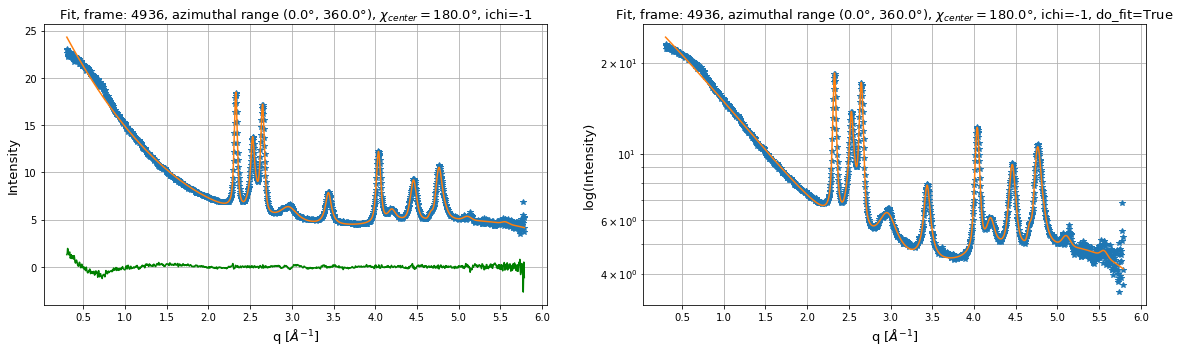

----> Succeed to fit with:  functools.partial(<bound method Fit1DPilatusData.fitting of <__main__.Fit1DPilatusData object at 0x7fca7c6557f0>>, ps1=True, tialn_ind=[], ps2=False, tin_ind=[], ps3=False, aln_ind=[], ps4=True, bkg_ho=True, do_fit=True, do_show=True) 
#######################################
[[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]]


 [[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.0000000

In [112]:
fit1=Fit1DPilatusData(source,output_path,q_array,integration_array,sigma_array,azimuth_array)
from time import time


#chi_index=range(0,8)
#chi_index=[0,1,2,3,5,6,8]
#chi_index=[0]
#chi_index=[x for x in range(0,fit1.nchi)]  #all available chi-directions


irows=[1806, 2990, 4935, 4361]
irows=[4936]
print(fit1.nchi)
chi_index=[-1]  #360


# Play with get_irows
#Shape frames
#x_start=35
#x_end=37
#y_start=67
#y_end=71
#x_len=71
#irows=fit1.get_irows(x_start, x_end, y_start, y_end,  x_len)
#print(irows)
#reshaped_irows=np.reshape(irows,(x_end-x_start,y_end-y_start))
#print(reshaped_irows)
#chi_index=[0]

#frame 1440, 1441 missing peak! (all one having a missing peak in area 20,23,20,23,71)


t0 = time()
output=fit1.multi_fitting(irows,chi_index)
t1 = time()
print(t1 - t0)

print(type(output[0]))
print(np.shape(output[0]))

fit1.save_fit_output(output[0],output[1],sample_file,output_path, irows=irows,chi_index=chi_index,x_start=None, x_end=None, y_start=None, y_end=None, x_len=None)

In [102]:
with h5py.File("2019-09-23T01_13_31.631114_F_2019-09-22T04_49_50.532438_scan_0007_pil1m_0000_integ_step_fit.h5",'r') as h5f:
    parray = h5f["/entry/fit/p"][()]

print(np.shape(parray))
print(parray)

(15, 1, 29, 4)
[[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]]


 [[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]]


 [[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00

In [91]:
import h5py

testname="Gudrun"

with h5py.File("./string.h5",'w') as h5f: 
    grp = h5f.create_group('/entry')
    h5f['/entry'].attrs["sample"]=testname

!h5dump ./string.h5

with h5py.File("./string.h5",'r') as h5f:
    name = h5f['/entry'].attrs["sample"]
    print(name)

    

HDF5 "./string.h5" {
GROUP "/" {
   GROUP "entry" {
      ATTRIBUTE "sample" {
         DATATYPE  H5T_STRING {
            STRSIZE H5T_VARIABLE;
            STRPAD H5T_STR_NULLTERM;
            CSET H5T_CSET_UTF8;
            CTYPE H5T_C_S1;
         }
         DATASPACE  SCALAR
         DATA {
         (0): "Gudrun"
         }
      }
   }
}
}
Gudrun


In [96]:
x_start=None
data=np.array([x_start, x_end, y_start, y_end,  x_len])
print(data)

[None 50 20 50 71]


In [110]:
a=np.asarray([1,2,3])
print(type(a))

<class 'numpy.ndarray'>


<class 'numpy.ndarray'>


2019-09-22T04_49_50.532438_scan_0007_pil1m_0000_integ_step
b'2019-09-22T04_49_50.532438_scan_0007_pil1m_0000_integ_step'


In [ ]:
# peak positions: parameter on pos=1
#dset_p[:,:,:,1]
# peak positions of 2nd peak(peak on pos 1): parameter on pos=1
#dset_p[:,:,1,1]

np.shape(output[1])
# first output, chi_index, all images, 2nd_peak, parameter 1 for this peak
result=output[0][0,:,2,1]
result_reshaped=np.reshape(result,(x_end-x_start,y_end-y_start))
#print(result_reshaped)

#print(reshaped_irows)

print(np.shape(reshaped_irows))
print(reshaped_irows.ndim)
print(type(result_reshaped))

plt.figure()
plt.imshow(result_reshaped)

!pwd
x_start=20
x_end=50
y_start=20
y_end=50
x_len=71
#output_name="2019-09-20T05_09_30.130000_scan_0000_pil1m_0000_integ_step.h5_20_50_20_50_71.npy"
np.save(output_name, output)

## Barrier, below tests
        

In [ ]:



#fit1.fitting(1500,nchi)
#fit1.fitting(1500,0) #I am missing a peak here, what it is?
#fit1.fitting(3000,1)
#fit1.fitting(3000,0)  #Here I need to switch of the TiN
#fit1.fitting(3000,1)
#fit1.fitting(3000,2)
#fit1.fitting(3000,3)
#fit1.fitting(3000,4)
#fit1.fitting(3000,5)
#fit1.fitting(3000,6)
#fit1.fitting(3000,8)
#fit1.fitting(3600,0)   #Here I need to switch of the TiN 
#fit1.fitting(3600,1)
#fit1.fitting(3600,2)
#fit1.fitting(3600,3)
#fit1.fitting(3600,4)
#fit1.fitting(3600,5)
#fit1.fitting(3600,6)
#fit1.fitting(3600,8)   #Here I need to switch of TiN, some TiAlN tialn_index=[4], and I need to increase the intensity for 200 TiAlN to 50

#fit1.fitting(2535,0)    #I switched here TiN off
#fit1.fitting(2535,1)
#fit1.fitting(2535,2)
#fit1.fitting(2535,3)    #TiN off 
#fit1.fitting(2535,4)
#fit1.fitting(2535,5)     #TiN off and  switched off tialn_index=[2]  111  TiAlN 
#fit1.fitting(2535,6)
#fit1.fitting(2535,8)

#fit1.fitting(1606,1)   # TiN off, all good
#fit1.fitting(1606,2)
#fit1.fitting(1606,3)
#fit1.fitting(1606,4)
#fit1.fitting(1606,5)
#fit1.fitting(1606,6)
#fit1.fitting(1606,8)
#fit1.fitting(1606,0)

#fit1.fitting(3831,0)  #Air, how to handle this?
#fit1.fitting(3831,1)
#fit1.fitting(3831,2)
#fit1.fitting(3831,3)
#fit1.fitting(3831,4)
#fit1.fitting(3831,5)
#fit1.fitting(3831,6)
#fit1.fitting(3831,8)


#fit1.fitting(2520,0) 
#fit1.fitting(2520,1)
#fit1.fitting(2520,2)
#fit1.fitting(2520,3)
#fit1.fitting(2520,4)
#fit1.fitting(2520,5)
#fit1.fitting(2520,6)
#fit1.fitting(2520,8)   #TiN off andf  tialn_index=[7] off!


#fit1.fitting(2823,0)    #TiN off and all good
#fit1.fitting(2823,1) 
#fit1.fitting(2823,2) 
#fit1.fitting(2823,3) 
#fit1.fitting(2823,4) 
#fit1.fitting(2823,5) 
#fit1.fitting(2823,6) 
#fit1.fitting(2823,8) 


#fit1.fitting(6,0)    #TiN on and TiAlN on
#fit1.fitting(6,1) 
#fit1.fitting(6,2)     #TiN on, TiAl on, but bkg not fixed!
#fit1.fitting(6,3) 
#fit1.fitting(6,4) 
#fit1.fitting(6,5) 
#fit1.fitting(6,6) 
#fit1.fitting(6,8) 

#irow=77
#fit1.fitting(irow,0)    
#fit1.fitting(irow,1) 
#fit1.fitting(irow,2)   #TiN on, TiAl on, but bkg not fixed!     
#fit1.fitting(irow,3) 
#fit1.fitting(irow,4) 
#fit1.fitting(irow,5) 
#fit1.fitting(irow,6) 
#fit1.fitting(irow,8) 


irow=2*77
#fit1.fitting(irow,0)    #TiN, TiAlN on
#fit1.fitting(irow,1) 
#fit1.fitting(irow,2)      ##TiN on, TiAl on, but bkg not fixed! Then it works    
#fit1.fitting(irow,3)       #TiN fixed=off
#fit1.fitting(irow,4) 
#fit1.fitting(irow,5)        ##TiN fixed=off
#fit1.fitting(irow,6) 
#fit1.fitting(irow,8) 


#irow=6*77
#fit1.fitting(irow,0)   
#fit1.fitting(irow,1) 
#fit1.fitting(irow,2)      #Guess Background     
#fit1.fitting(irow,3)      #TiN off? maybe guess
#fit1.fitting(irow,4) 
#fit1.fitting(irow,5) 
#fit1.fitting(irow,6) 
#fit1.fitting(irow,8) 

#index=[5,10,15,20,30,35,40,50]
#index=[20]
#offset=40


#for i in index:
    #irow=i*71+offset
    #print(irow)
    #fit1.fitting(irow,0)    
#    fit1.fitting(irow,1) 
    #fit1.fitting(irow,2)    
    #fit1.fitting(irow,3) 
    #fit1.fitting(irow,4) 
    #fit1.fitting(irow,5) 
    #fit1.fitting(irow,6) 
    #fit1.fitting(irow,8) 





In [ ]:
#mesh sx -16.5 -9.5 70 sy -3.5 3.5 70 1
np.shape(q_array)

In [ ]:
2823 % 71

In [ ]:
39*71+54

In [ ]:
print("\033[92mHello\033[0mWorld")

In [ ]:
def get_irows(x_start, x_end, y_start, y_end,  x_len):
    output = []
    for i in range(y_start, y_end):
        y_offset = x_len * i
        for j in range(x_start + y_offset, x_end + y_offset):
            output.append(j)
    return output
        
        


In [ ]:
#def get_irows(x_start, x_end, y_start, y_end,  x_len):
#    for i in range(y_start, y_end):
#        y_offset = x_len * i
#        yield range(x_start + y_offset, x_end + y_offset)
    

In [ ]:
def fun(a,b,c):
    return a,b,c

test=fun(1,2,3)
print(test[2])

In [ ]:
#Shape frames

a=get_irows(20,30,40,50,71)
print(a)
np.reshape(a,(30-20,50-40))

In [ ]:
!pwd

In [ ]:
!ls

In [ ]:
[x for x in range(16,28)]

In [ ]:
def get_irows(x_start, x_end, y_start, y_end,  x_len):
        output = []
        for i in range(y_start, y_end):
            y_offset = x_len * i
            for j in range(x_start + y_offset, x_end + y_offset):
                output.append(j)
        return output

x_start=0
x_end=3
y_start=68
y_end=71
x_len=71

x_start=39
x_end=41
y_start=67
y_end=69
x_len=71

matrix=get_irows(x_start, x_end, y_start, y_end,  x_len)
print(matrix)
resh_matrix=np.reshape(matrix,(y_end-y_start,x_end-x_start))
print(resh_matrix)


#calculated back from image number to row, column index
index=4796
width=71
row    = (int)(index / width)
column = index % width

print(row, column)

In [ ]:
4795
